In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
! pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:010m


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib

In [3]:
ls

app.py                              requirements.txt
credit-card-fraud-detection.ipynb   score.py
default_of_credit_card_clients.csv  src/
myenv/                              xgb_classifier_model.pkl


In [5]:
df = pd.read_csv('default_of_credit_card_clients.csv',skiprows=1,index_col=0)

In [6]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [7]:
# All columns in this dataset are result of PCA (Prinicpal Component Analysis) transform, to mask off sensitive data.

print(df.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [8]:
print(df.shape)

(30000, 24)


In [9]:
# The target variable is "Class", which takes up values 1 for fraudulent transactions and value 0 for valid transactions

print(df.describe())

            LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186

In [10]:
print(df.shape)

(30000, 24)


## Data Visualization

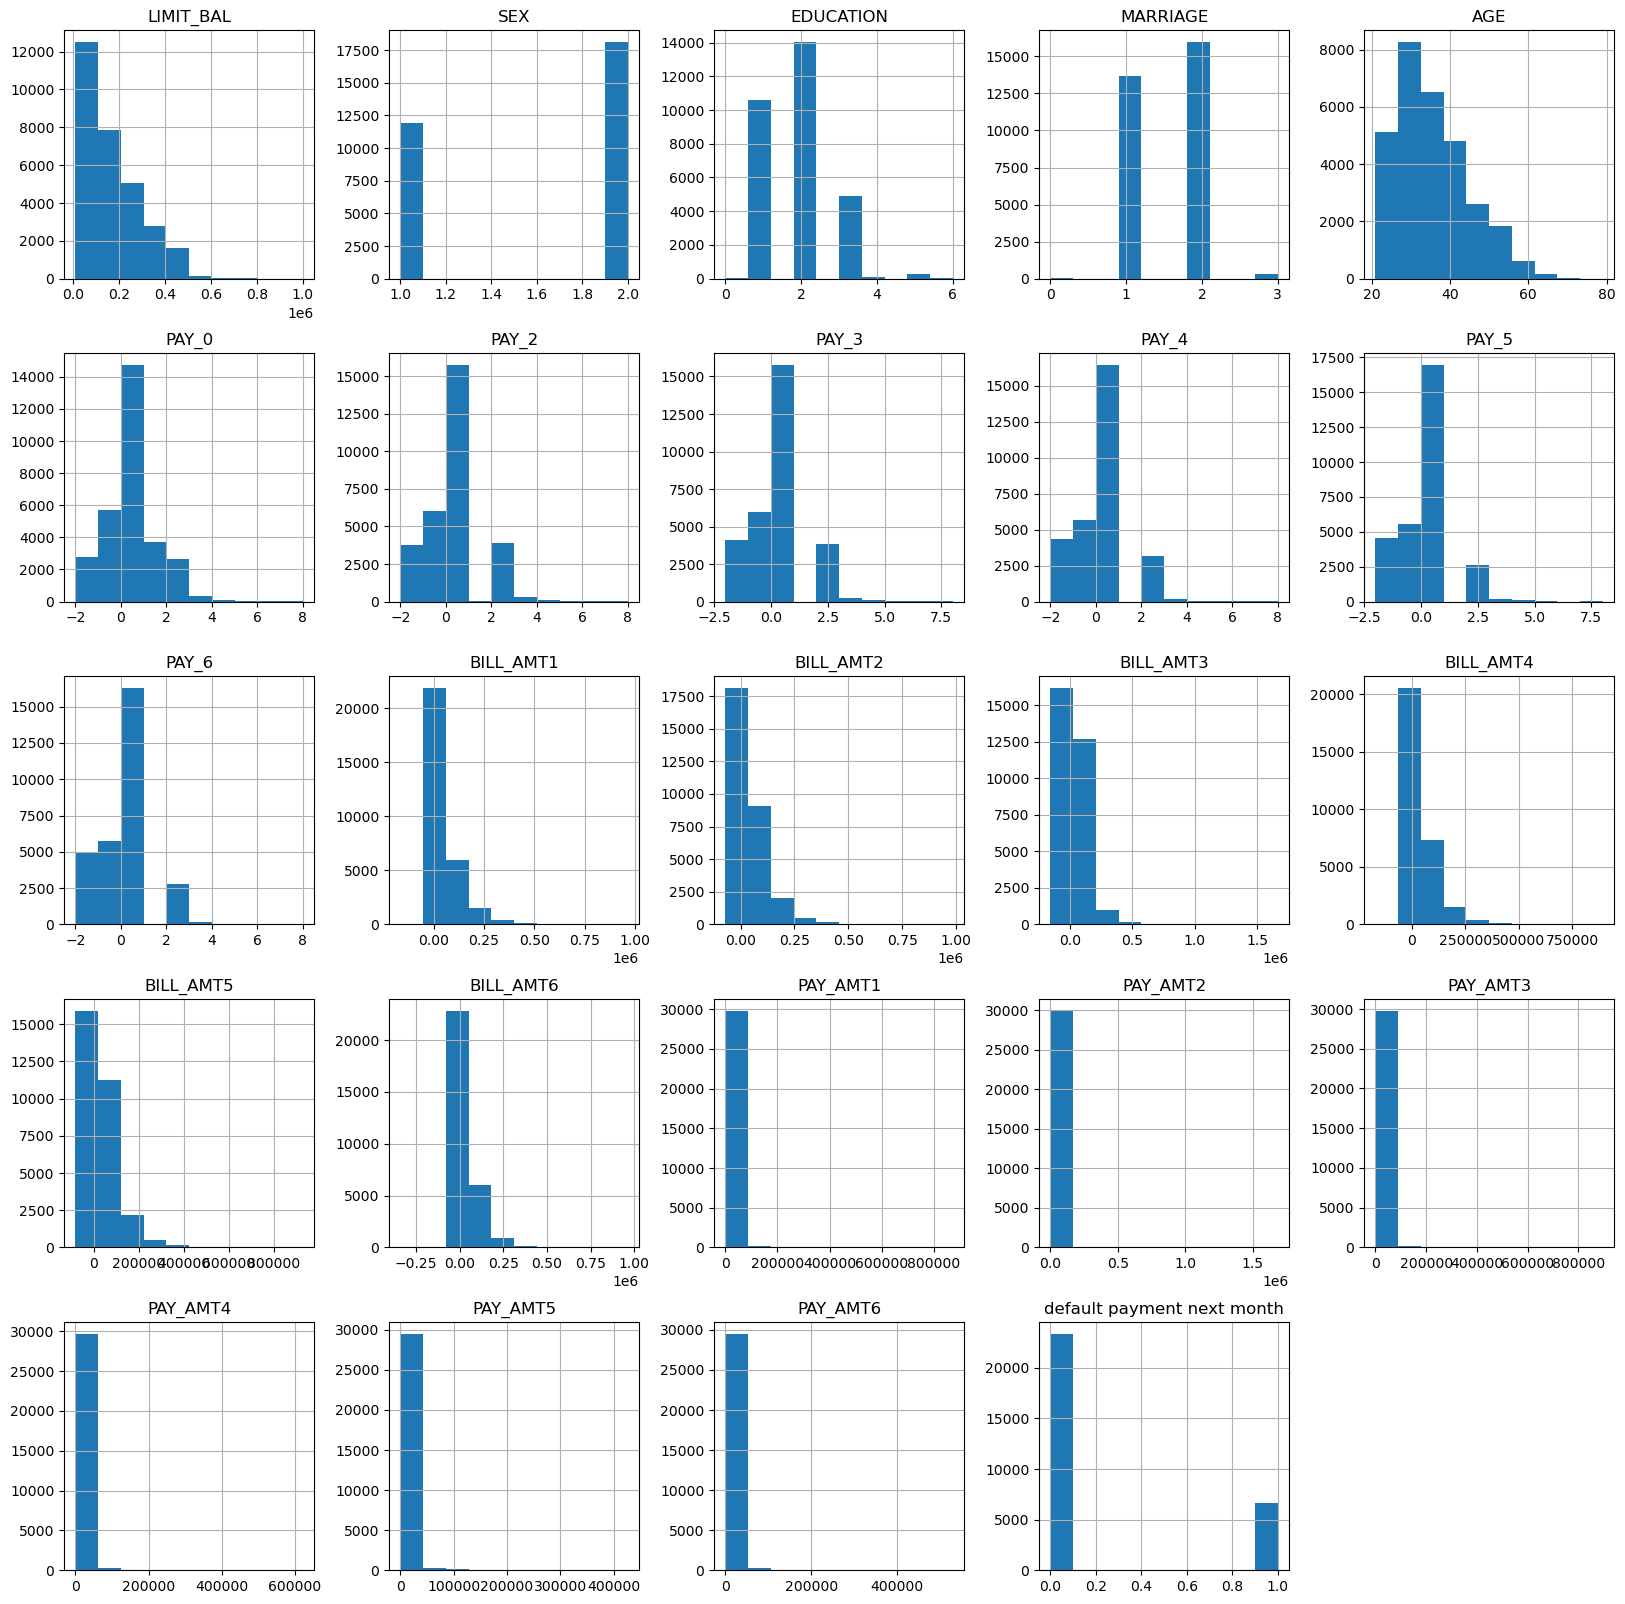

In [11]:
df.hist(figsize = (20, 20))
plt.show()

In [12]:
fraudulent_transactions = df[df['default payment next month'] == 1]
valid_transactions = df[df['default payment next month'] == 0]

outlier_fraction = float(len(fraudulent_transactions)) / float(len(valid_transactions))

print(f"Fraudent transactions: {len(fraudulent_transactions)}")
print(f"Valid transactions: {len(valid_transactions)}")
print(f"Outlier fraction: {outlier_fraction}")
print(f"Outlier %: {round(outlier_fraction*100, 2)}")

Fraudent transactions: 6636
Valid transactions: 23364
Outlier fraction: 0.2840267077555213
Outlier %: 28.4


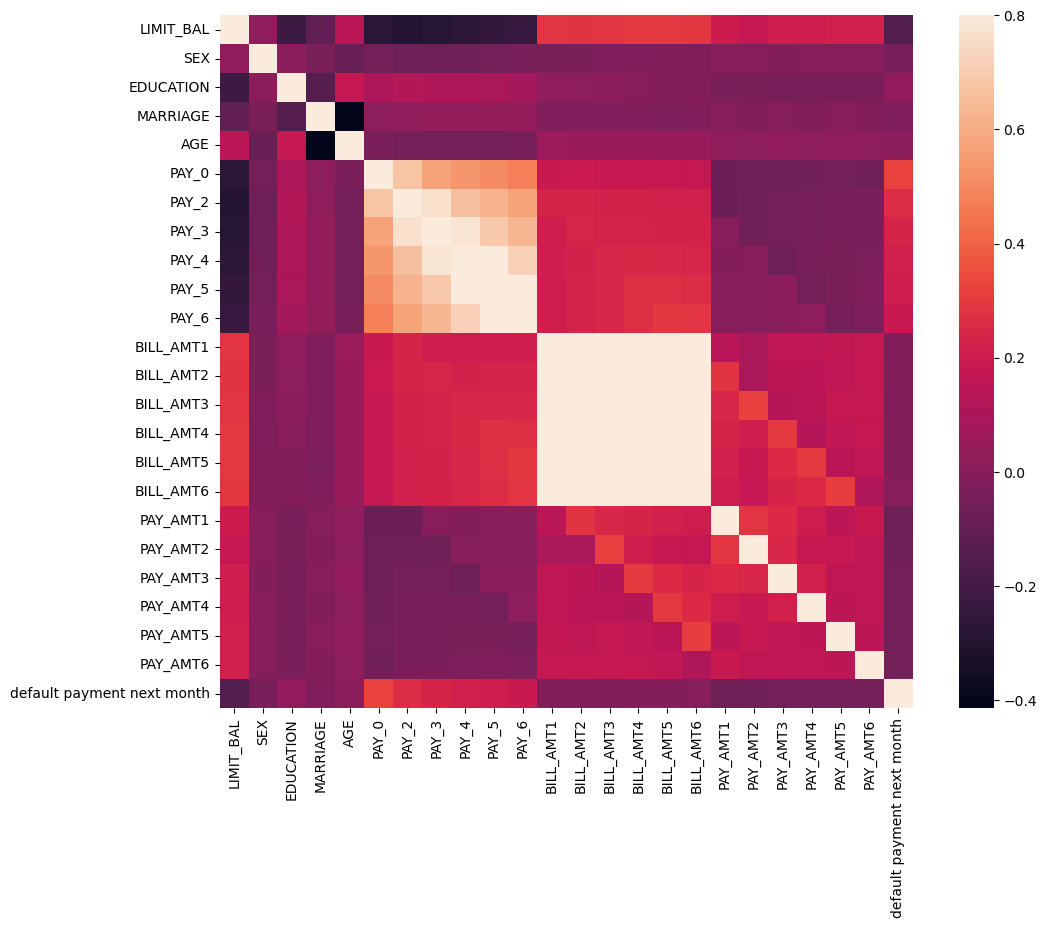

In [13]:
# Correlation matrix

corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = 0.8, square = True)
plt.show()

## Separating input variables & target class

In [20]:


# Split your features and target
columns = df.columns.tolist()
columns = [c for c in columns if c not in ["default payment next month"]]
target = "default payment next month"

X = df[columns]
y = df[target]

print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train your model
model = XGBClassifier()
model.fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

(30000, 23)
(30000,)
Cross-validation scores: [0.801      0.8025     0.81716667 0.82683333 0.81483333]
Mean cross-validation score: 0.8124666666666667


In [21]:
joblib.dump(model, 'xgb_model.pkl')

print("Model saved as xgb_model.pkl")

Model saved as xgb_model.pkl


## Isolation Forest Algorithm

In [62]:
clf = IsolationForest(max_samples = len(X), contamination = outlier_fraction, random_state = 1)
clf.fit(X)
scores_pred = clf.decision_function(X)
y_pred = clf.predict(X) # Isolation Forest predicts 1 for valid transactions, while it predicts -1 for fraudulent

In [63]:
print(f"Valid transactions predicted by Isolation Forest: {len(y_pred[y_pred == 1])}") # Valid
print(f"Fraudulent transactions predicted by Isolation Forest: {len(y_pred[y_pred == -1])}") # Fraudulent

Valid transactions predicted by Isolation Forest: 21479
Fraudulent transactions predicted by Isolation Forest: 8521


In [64]:
# A transformation in required in y_pred array, as Isolation Forest predicts 1 for valid transactions, while it predicts -1 for fraudulent, but in the
# dataset, we have "Class" variable as 0 for valid transactions, 1 for fraudulent transactions.

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [65]:
print(f"Accuracy score: {accuracy_score(y, y_pred)}")

Accuracy score: 0.6673


In [66]:
n_errors = (y != y_pred).sum()
print(f"Total incorrect predictions: {n_errors}")

Total incorrect predictions: 9981


In [67]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     23364
           1       0.30      0.39      0.34      6636

    accuracy                           0.67     30000
   macro avg       0.56      0.57      0.56     30000
weighted avg       0.70      0.67      0.68     30000



## Local Outlier Factor Algorithm

In [76]:
clf = LocalOutlierFactor(n_neighbors = 20, contamination = outlier_fraction)
y_pred = clf.fit_predict(X)
scores_pred = clf.negative_outlier_factor_

In [77]:
print(f"Valid transactions predicted by Local Outlier Factor: {len(y_pred[y_pred == 1])}") # Valid
print(f"Fraudulent transactions predicted by Local Outlier Factor: {len(y_pred[y_pred == -1])}") # Fraudulent

Valid transactions predicted by Local Outlier Factor: 21479
Fraudulent transactions predicted by Local Outlier Factor: 8521


In [78]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [79]:
print(f"Accuracy score: {accuracy_score(y, y_pred)}")

Accuracy score: 0.6084333333333334


In [72]:
n_errors = (y != y_pred).sum()
print(f"Total incorrect predictions: {n_errors}")

Total incorrect predictions: 11747


In [80]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74     23364
           1       0.20      0.26      0.22      6636

    accuracy                           0.61     30000
   macro avg       0.49      0.48      0.48     30000
weighted avg       0.64      0.61      0.62     30000



In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import pickle

# Assuming the dataset is loaded in a variable 'data', here is the process to build and save the model.

# Load dataset (assuming it's a CSV file)
# data_path = 'data/default_of_credit_card_clients.csv'  # Replace with actual path if different
# data = pd.read_csv(data_path)

# Separate the features and target variable
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Build a RandomForest model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_res, y_train_res)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve and AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_probs)
auprc = auc(recall, precision)

# Save the model
model_filename = 'fraud_detection_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Output the AUPRC value and save the model path
auprc, model_filename

(0.4921367939354107, 'fraud_detection_model.pkl')

In [83]:
auprc 

0.4921367939354107

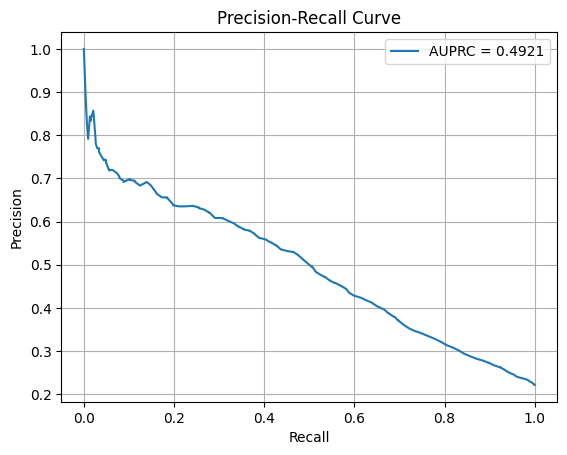

(None, 0.4921367939354107, 'precision_recall_curve.png')

In [84]:
import matplotlib.pyplot as plt

# Adding the plot of the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)

# Save the plot to a file
plot_filename = 'precision_recall_curve.png'
plt.savefig(plot_filename)

# Display the plot and return the AUPRC value along with plot file path
plt.show(), auprc, plot_filename

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

In [6]:
df = pd.read_csv('/Users/nguinabejosue/Desktop/Fraud_Detection/data/default_of_credit_card_clients.csv',skiprows=1,index_col=0)

# Define features and target
X = df.drop('default payment next month',axis=1)  # Replace 'target_column' with your actual target column
y = df['default payment next month']

In [11]:
df['default payment next month'].value_counts()

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Since it's a classification task
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False       # Disable label encoding
)

xgb_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [13]:
# Make predictions
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate the results
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.64      0.38      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:
 [[4406  281]
 [ 819  494]]
ROC AUC Score: 0.7705693227739672


In [14]:
import joblib

# Save the model
joblib.dump(xgb_clf, 'xgb_classifier_model.pkl')

# Load the model later (if needed)
# loaded_model = joblib.load('xgb_classifier_model.pkl')

['xgb_classifier_model.pkl']

In [59]:
# Load the model later (if needed)
loaded_model = joblib.load('xgb_classifier_model.pkl')

In [60]:
X_train.shape

(24000, 23)

In [64]:
input_data = (5,166,72,19,175,25.8,0.587,51,5,166,72,19,175,25.8,0.587,51,2,3,4,5,6,2,3)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

[1]
The person is diabetic


In [15]:
!pip install azureml-sdk

INFO: pip is looking at multiple versions of azureml-sdk to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of azureml-sdk to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 623.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of azureml-dataprep to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of azureml-automl-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is loo

In [17]:
!pip install azureml

In [19]:
!pip install azureml.core

  Using cached azureml_core-1.57.0.post3-py3-none-any.whl.metadata (3.1 kB)
  Using cached backports.tempfile-1.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached azure_core-1.31.0-py3-none-any.whl.metadata (39 kB)
  Using cached argcomplete-3.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached paramiko-3.5.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached azure_mgmt_resource-23.1.1-py3-none-any.whl.metadata (37 kB)
  Using cached azure_mgmt_containerregistry-10.3.0-py3-none-any.whl.metadata (23 kB)
  Using cached azure_mgmt_storage-21.2.1-py3-none-any.whl.metadata (31 kB)
  Using cached azure_mgmt_keyvault-10.3.1-py3-none-any.whl.metadata (15 kB)
  Using cached azure_mgmt_authorization-4.0.0-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 498.5 kB/s eta 0:00:00a 0:00:01
  Using cached azure_graphrbac-0.61.1-py2.py3-none-any.whl.metadata (10 kB)
  Using cached azure_common-1.1.28-py2.py3-none-any.whl.metadata (5.0 kB)
  Using cached m

In [65]:
import os
import json
import requests

from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice

In [66]:
ls

config.json                        main.py
credit-card-fraud-detection.ipynb  score.py
data/                              src/
fraud_detection_model.pkl          xgb_classifier_model.pkl


In [67]:
# laoding the configuration file - standard way - use .env file and load_dotenv from python-dotenv module
config_file_path = "config.json"

# Read JSON data into a dictionary
with open(config_file_path, 'r') as file:
    data = json.load(file)

subscription_id = data["subscription_id"]
resource_group = data["resource_group"]  
workspace_name = data["workspace_name"]
region = data["region"]

In [68]:
print(resource_group)
print(workspace_name)
print(region)

defaultpayementdetection
defaultpayementdetection
Central US


In [69]:
# Create a workspace
ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group,
                      location=region)

print(f'Workspace {workspace_name} created')

Deploying AppInsights with name defaultpinsights393f1949.
Deployed AppInsights with name defaultpinsights393f1949. Took 5.54 seconds.
Deploying StorageAccount with name defaultpstorage300891e15.
Deploying KeyVault with name defaultpkeyvaultbf73c1f5.
Deployed KeyVault with name defaultpkeyvaultbf73c1f5. Took 21.67 seconds.
Deploying Workspace with name defaultpayementdetection.
Deployed StorageAccount with name defaultpstorage300891e15. Took 25.16 seconds.
Deployed Workspace with name defaultpayementdetection. Took 18.92 seconds.
Workspace defaultpayementdetection created


In [70]:
# Specify the path to your  model file
model_path = 'xgb_classifier_model.pkl'

In [71]:
model_name='default_payment_next_month_model'

In [78]:
# Register the model in Azure Machine Learning
registered_model = Model.register(model_path=model_path, model_name=model_name, workspace=ws)

Registering model default_payment_next_month_model


In [81]:
# Create a Conda environment for your scikit-learn model
conda_env = Environment('mycondaenv')
conda_env.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'])

In [82]:
# Create an InferenceConfig
inference_config = InferenceConfig(entry_script='score.py', environment=conda_env)

In [83]:
# Specify deployment configuration for ACI
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1.7)

In [85]:
service = Model.deploy(workspace=ws,
                       name='default-payment-next-month-model',
                       models=[registered_model],
                       inference_config=inference_config,
                       deployment_config=aci_config)
service.wait_for_deployment(show_output=True)

/var/folders/y6/0w1_g76n62s37y43p6nbdsgc0000gn/T/ipykernel_55672/3811943719.py:1: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(workspace=ws,


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-10-05 15:25:14+00:00 Creating Container Registry if not exists.
2024-10-05 15:25:14+00:00 Registering the environment.
2024-10-05 15:25:16+00:00 Use the existing image.
2024-10-05 15:25:17+00:00 Generating deployment configuration.
2024-10-05 15:25:18+00:00 Submitting deployment to compute.
2024-10-05 15:25:26+00:00 Checking the status of deployment default-payment-next-month-model..
2024-10-05 15:26:40+00:00 Checking the status of inference endpoint default-payment-next-month-model.
Failed


Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 38a8e068-c888-4400-b1ea-3c7ce89508cb
More information can be found using '.get_logs()'
Error:
{
  "code": "AciDeploymentFailed",
  "statusCode": 400,
  "message": "Aci Deployment failed with exception: Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details.",
  "details": [
    {
      "code": "CrashLoopBackOff",
      "message": "Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details."
    }
  ]
}



WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 38a8e068-c888-4400-b1ea-3c7ce89508cb
More information can be found using '.get_logs()'
Error:
{
  "code": "AciDeploymentFailed",
  "statusCode": 400,
  "message": "Aci Deployment failed with exception: Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details.",
  "details": [
    {
      "code": "CrashLoopBackOff",
      "message": "Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details."
    }
  ]
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Unhealthy\nOperation ID: 38a8e068-c888-4400-b1ea-3c7ce89508cb\nMore information can be found using '.get_logs()'\nError:\n{\n  \"code\": \"AciDeploymentFailed\",\n  \"statusCode\": 400,\n  \"message\": \"Aci Deployment failed with exception: Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details.\",\n  \"details\": [\n    {\n      \"code\": \"CrashLoopBackOff\",\n      \"message\": \"Error in entry script, ModuleNotFoundError: No module named 'xgboost', please run print(service.get_logs()) to get details.\"\n    }\n  ]\n}"
    }
}

In [77]:
print(service.get_logs())

None


In [35]:
scoring_uri = service.scoring_uri

In [36]:
scoring_uri

In [37]:
print(service.get_logs())

None


In [38]:
from azureml.core import Model

models = Model.list(ws)
for model in models:
    print(model.name, model.version)

default_payment_next_month_model 1


In [41]:
import joblib
from azureml.core.model import Model

model_path = Model.get_model_path('xgb_classifier_model.pkl')  
model = joblib.load(model_path)
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


In [43]:
import numpy as np
data = np.array(data).reshape(1, -1)
print("Input shape:", data.shape)

Input shape: (1, 1)
